In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
from pathlib import Path
import pickle
import os
import glob
import re
import sys

from ipywidgets import interact, Dropdown

from photutils.aperture import CircularAperture, aperture_photometry
from spectral_cube import SpectralCube
from scipy.interpolate import interp1d
from astropy.time import Time
from astropy.coordinates import SkyCoord
from astropy.table import Table
import astropy.units as u
from astropy.wcs import WCS
from astropy.constants import c
from astropy.io import fits
from astropy.visualization import simple_norm, imshow_norm

home_directory = "/d/ret1/Taylor/jupyter_notebooks/Research" 
parent_dir = Path(home_directory).resolve() 
os.chdir(parent_dir) #TJ change working directory to be the parent directory

from Py_files.Basic_analysis import * #TJ import basic functions from custom package
from Py_files.Image_vs_spectra import *
from Py_files.Convolution_script import *
from Py_files.Get_feature_fluxes import *


True
/d/ret1/Taylor/stpsf-data/


In [2]:

#IFU_files = glob.glob('Data_files/IFU_files/*s3d.fits') #TJ this is not correctly sorted, run this and copy into line below
IFU_files = [ 'Data_files/IFU_files/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits',
             'Data_files/IFU_files/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits',
             'Data_files/IFU_files/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits',
             'Data_files/IFU_files/SW_IFU_ch1-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/SW_IFU_ch2-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/SW_IFU_ch3-shortmediumlong_s3d.fits',
             'Data_files/IFU_files/SW_IFU_ch4-shortmediumlong_s3d.fits',
            ]
Grant_conv_IFU_files = ['Data_files/IFU_files/jw03435-o012_t014_nirspec_g140m-f100lp_s3d_conv17p1.fits',
                        'Data_files/IFU_files/jw03435-o012_t014_nirspec_g235m-f170lp_s3d_conv17p1.fits',
                        'Data_files/IFU_files/jw03435-o012_t014_nirspec_g395m-f290lp_s3d_conv17p1.fits',
                        'Data_files/IFU_files/SW_IFU_ch1-shortmediumlong_s3d_conv17p1um.fits',
                        'Data_files/IFU_files/SW_IFU_ch2-shortmediumlong_s3d_conv17p1um.fits',
                        'Data_files/IFU_files/SW_IFU_ch3-shortmediumlong_s3d_conv17p1um.fits',
                        'Data_files/IFU_files/SW_IFU_ch4-shortmediumlong_s3d_conv17p1um.fits']


loc = [202.4340450, 47.1732517] 
radius = 0.75*u.arcsec
aperture_size = (np.pi*(radius**2).to('sr'))

def combine_spectra(fits_files, loc, radius, anchor_idx=0, show_plot=False):
    '''
    Combine multiple spectral segments using a specified anchor spectrum for alignment
    
    Parameters
    ----------
    fits_files : list of str
        List of paths to FITS files to combine (must be in wavelength order)
    anchor_idx : int, optional
        Index of the file to use as anchor/reference (default: 0)
    loc : list or SkyCoord
        [RA, Dec] in degrees or SkyCoord object for extraction
    radius : astropy Quantity
        Aperture radius with units (e.g., 0.75*u.arcsec)
    show_plot : bool, optional
        Whether to show diagnostic plots (default: False)
        
    Returns
    -------
    dict
        Combined spectrum with 'wavelength' and 'intensity' keys
    '''
    
    # Load anchor spectrum
    anchor = get_IFU_spectrum(fits_files[anchor_idx], loc, radius, replace_negatives=1e-1)
    combined = {'wavelength': anchor['wavelength'].copy(),
                'intensity': anchor['intensity'].copy()}
    
    for i, file in enumerate(fits_files):
        if i == anchor_idx:
            continue  # Skip the anchor file
            
        # Load current spectrum
        current = get_IFU_spectrum(file, loc, radius, replace_negatives=1e-1)
        
        # Find overlap with combined spectrum
        mask_combined = (combined['wavelength'] >= current['wavelength'][0]) & \
                        (combined['wavelength'] <= current['wavelength'][-1])
        mask_current = (current['wavelength'] >= combined['wavelength'][0]) & \
                       (current['wavelength'] <= combined['wavelength'][-1])
        
        # Skip if no overlap
        if not np.any(mask_combined):
            print(f"No overlap between anchor and {file}")
            continue
            
        # Calculate offset relative to anchor
        current_interp = np.interp(
            combined['wavelength'][mask_combined],
            current['wavelength'][mask_current],
            current['intensity'][mask_current]
        )
        offset = np.nanmedian(combined['intensity'][mask_combined] - current_interp)
        
        # Apply correction
        corrected_current = current['intensity'] + offset
        
        # Combine spectra
        non_overlap_mask = ~((current['wavelength'] >= combined['wavelength'][0]) & 
                            (current['wavelength'] <= combined['wavelength'][-1]))
        
        combined['wavelength'] = np.concatenate([
            combined['wavelength'],
            current['wavelength'][non_overlap_mask]
        ])
        combined['intensity'] = np.concatenate([
            combined['intensity'],
            corrected_current[non_overlap_mask]
        ])
        
        # Sort by wavelength (in case files weren't perfectly ordered)
        sort_idx = np.argsort(combined['wavelength'])
        combined['wavelength'] = combined['wavelength'][sort_idx]
        combined['intensity'] = combined['intensity'][sort_idx]
        
        if show_plot:
            plt.figure(figsize=(12,6))
            plt.plot(combined['wavelength'], combined['intensity'], 'k-', label='Combined')
            plt.plot(current['wavelength'], current['intensity'], 'r-', alpha=0.5, label='Original')
            plt.plot(current['wavelength'], corrected_current, 'b--', alpha=0.7, label='Aligned')
            plt.yscale('log')
            plt.title(f"After adding {file}")
            plt.legend()
            plt.show()
    
    return combined
    

In [6]:
#TJ this cell doesnt need to be run if the files exist already
for i, file in enumerate(IFU_files):
    convolve_using_reference(file, 'F2100W', f'convolved_to_2100_part{i+1}.fits')


Using PSF at 2.0795e-05 meters (filter pivot wavelength) for all slices


Convolving to F2100W PSF:   0%|          | 0/1447 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as convolved_to_2100_part1.fits
Using PSF at 2.0795e-05 meters (filter pivot wavelength) for all slices


Convolving to F2100W PSF:   0%|          | 0/1425 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as convolved_to_2100_part2.fits
Using PSF at 2.0795e-05 meters (filter pivot wavelength) for all slices


Convolving to F2100W PSF:   0%|          | 0/1341 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as convolved_to_2100_part3.fits
Using PSF at 2.0795e-05 meters (filter pivot wavelength) for all slices


Convolving to F2100W PSF:   0%|          | 0/3438 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as convolved_to_2100_part4.fits
Using PSF at 2.0795e-05 meters (filter pivot wavelength) for all slices


Convolving to F2100W PSF:   0%|          | 0/3224 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as convolved_to_2100_part5.fits
Using PSF at 2.0795e-05 meters (filter pivot wavelength) for all slices


Convolving to F2100W PSF:   0%|          | 0/2572 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as convolved_to_2100_part6.fits
Using PSF at 2.0795e-05 meters (filter pivot wavelength) for all slices


Convolving to F2100W PSF:   0%|          | 0/1834 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as convolved_to_2100_part7.fits



Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by -1.4457610186240124e-31
This corresponds to a correction of -0.050312492499347966

Stitching RIGHT: file 2 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by -8.743626071288438e-32
This corresponds to a correction of -0.0356838776236785

Stitching RIGHT: file 3 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 4.206735683517058e-31
This corresponds to a correction of 0.12154489524998748

Stitching RIGHT: file 4 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by -3.1799236708851104e-31
This corresponds to a correction of -0.003240450495778304

Stitching RIGHT: file 5 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by -1.3895929322505089e-30
This corresponds to a correction of -0.03130050939

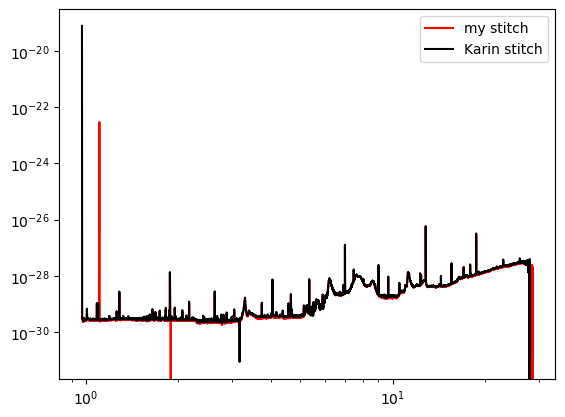

In [10]:
common_convolution_files = np.array(glob.glob('Data_files/IFU_files/convolved_to_2100*'))
part = [int(x.split('part')[1].split('.f')[0]) for x in common_convolution_files]
sorted_indices = np.argsort(part)

files = common_convolution_files[sorted_indices]
full_spectrum = stitch_spectra(files, loc, radius)
with open("Data_files/misc_data/Karin_SDuval_reduction_stitched.pkl", "wb") as file:
    pickle.dump(full_spectrum, file)

Karin = load_and_sort_convolved_Karin_spectrum('Data_files/ARM2_HII2_conv_stitched_test.dat')
plt.plot(full_spectrum['wavelength']*1e6, full_spectrum['intensity'], color = 'red', label = 'my stitch')
plt.plot(Karin['wavelength']*1e6, Karin['intensity'], color = 'black', label = 'Karin stitch')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()


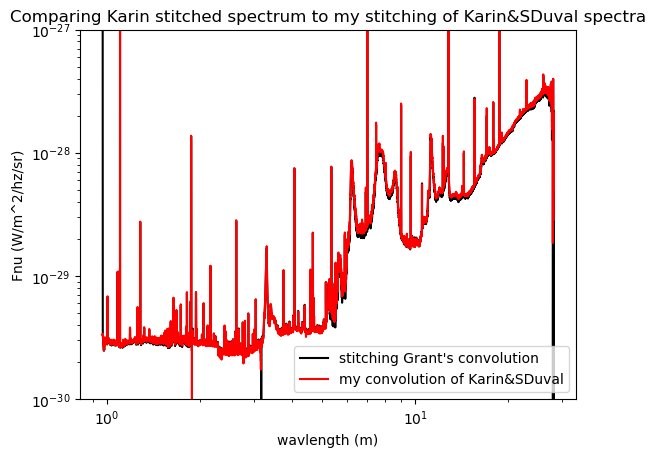

In [11]:
#Anchored to first file
Karin = load_and_sort_convolved_Karin_spectrum('Data_files/ARM2_HII2_conv_stitched_test.dat')
with open("Data_files/misc_data/Karin_SDuval_reduction_stitched.pkl", "rb") as file:
    full_spectrum = pickle.load(file)
test_range = range(0,len(Karin))
plt.plot(Karin['wavelength']*1e6, Karin['intensity'], color = 'black', label = "stitching Grant's convolution")
plt.plot(full_spectrum['wavelength'][test_range]*1e6, full_spectrum['intensity'][test_range]*1.1, color = 'red', label = 'my convolution of Karin&SDuval')
plt.xscale('log')
plt.yscale('log')
plt.title('Comparing Karin stitched spectrum to my stitching of Karin&SDuval spectra')
plt.ylabel('Fnu (W/m^2/hz/sr)')
plt.xlabel('wavlength (m)')
plt.ylim([1e-30, 1e-27])
plt.legend()
plt.show()

In [6]:
type(radius)

astropy.units.quantity.Quantity

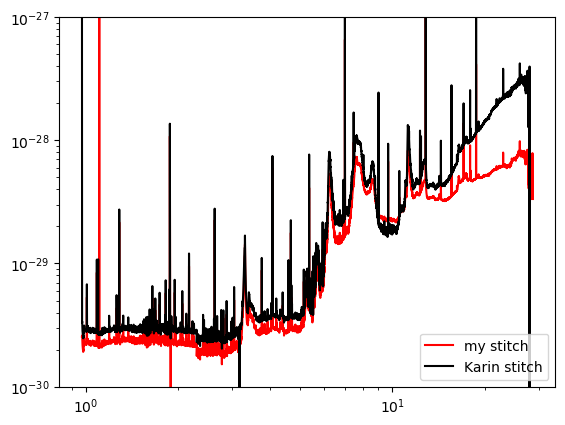

In [7]:
#Anchored to second file
files = ['Data_files/IFU_files/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits', 
         'Data_files/IFU_files/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits',
         'Data_files/IFU_files/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits',
         'Data_files/IFU_files/SW_IFU_ch1-shortmediumlong_s3d_conv17p1um.fits',
         'Data_files/IFU_files/SW_IFU_ch2-shortmediumlong_s3d_conv17p1um.fits',
         'Data_files/IFU_files/SW_IFU_ch3-shortmediumlong_s3d_conv17p1um.fits',
         'Data_files/IFU_files/SW_IFU_ch4-shortmediumlong_s3d_conv17p1um.fits']
'''
full_spectrum = stitch_spectra(files, loc, radius, anchor_idx=0)'''
with open("Data_files/misc_data/Karin_Grant_convolved.pkl", "wb") as file:
    pickle.dump(full_spectrum, file)
with open("Data_files/misc_data/Karin_Grant_convolved.pkl", "rb") as file:
    full_spectrum = pickle.load(file)
plt.plot(full_spectrum['wavelength']*1e6, full_spectrum['intensity'], color = 'red', label = 'my stitch')
plt.plot(Karin['wavelength']*1e6, Karin['intensity'], color = 'black', label = 'Karin stitch')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-30, 1e-27])
plt.legend()
plt.show()

Using PSF at 17.099999999999998 microns (filter pivot wavelength) for all slices


Convolving to F2100W PSF:   0%|          | 0/1447 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw_IFU_convolved_to17p1um_part_0
Using PSF at 17.099999999999998 microns (filter pivot wavelength) for all slices


Convolving to F2100W PSF:   0%|          | 0/1425 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw_IFU_convolved_to17p1um_part_1
Using PSF at 17.099999999999998 microns (filter pivot wavelength) for all slices


Convolving to F2100W PSF:   0%|          | 0/1341 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw_IFU_convolved_to17p1um_part_2
Using PSF at 17.099999999999998 microns (filter pivot wavelength) for all slices


Convolving to F2100W PSF:   0%|          | 0/3438 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw_IFU_convolved_to17p1um_part_3
Using PSF at 17.099999999999998 microns (filter pivot wavelength) for all slices


Convolving to F2100W PSF:   0%|          | 0/3224 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw_IFU_convolved_to17p1um_part_4
Using PSF at 17.099999999999998 microns (filter pivot wavelength) for all slices


Convolving to F2100W PSF:   0%|          | 0/2572 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw_IFU_convolved_to17p1um_part_5
Using PSF at 17.099999999999998 microns (filter pivot wavelength) for all slices


Convolving to F2100W PSF:   0%|          | 0/1834 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw_IFU_convolved_to17p1um_part_6

Stitching RIGHT: file 1 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by -1.4436999312123924e-31

Stitching RIGHT: file 2 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by -8.347450751545923e-32

Stitching RIGHT: file 3 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 1.3545035827699361e-30

Stitching RIGHT: file 4 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 1.195549178304374e-29

Stitching RIGHT: file 5 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 1.4597188089012781e-29

Stitching RIGHT: file 6 to combined
Stitching these sections required the longer wavelength spectrum to be corrected by 3.388956799416567e-29
Newly combined spectrum goes from 9.703180286160204e-07 to 2.870

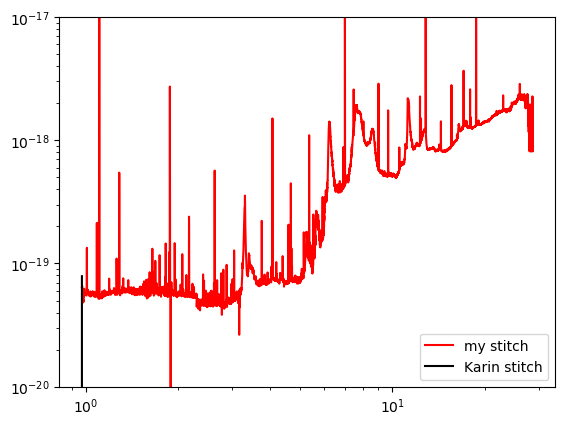

In [8]:
#Anchored to second file
unconvolved_files = ['Data_files/IFU_files/jw03435-o012_t014_nirspec_g140m-f100lp_s3d.fits', 
         'Data_files/IFU_files/jw03435-o012_t014_nirspec_g235m-f170lp_s3d.fits',
         'Data_files/IFU_files/jw03435-o012_t014_nirspec_g395m-f290lp_s3d.fits',
         'Data_files/IFU_files/SW_IFU_ch1-shortmediumlong_s3d.fits',
         'Data_files/IFU_files/SW_IFU_ch2-shortmediumlong_s3d.fits',
         'Data_files/IFU_files/SW_IFU_ch3-shortmediumlong_s3d.fits',
         'Data_files/IFU_files/SW_IFU_ch4-shortmediumlong_s3d.fits']
convolved_files = []
filter = 'F2100W'
for i, file in enumerate(unconvolved_files):
    convolved_files.append(convolve_using_reference(file, filter, reference_wl = 17.1e-6, output_file=f'jw_IFU_convolved_to17p1um_part_{i}'))

full_spectrum = stitch_spectra(convolved_files, loc, radius, anchor_idx=0)
with open("Data_files/misc_data/karin_SDuval_convolved_to17p1um.pkl", "wb") as file:
    pickle.dump(full_spectrum, file)
plt.plot(full_spectrum['wavelength']*1e6, full_spectrum['intensity']/aperture_size, color = 'red', label = 'my stitch')
plt.plot(Karin['wavelength']*1e6, Karin['intensity'], color = 'black', label = 'Karin stitch')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e-20, 1e-17])
plt.legend()
plt.show()

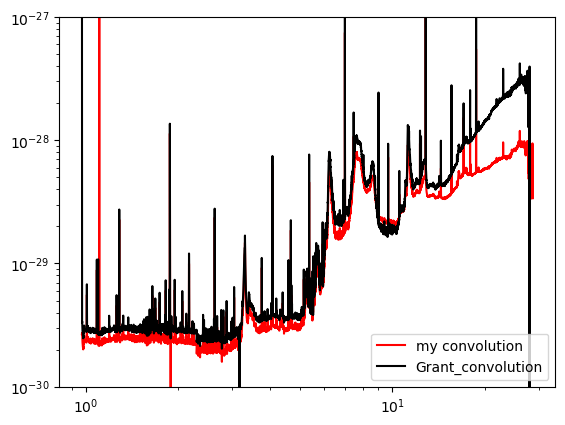

In [9]:
plt.plot(full_spectrum['wavelength']*1e6, full_spectrum['intensity'], color = 'red', label = 'my convolution')
plt.plot(Karin['wavelength']*1e6, Karin['intensity'], color = 'black', label = 'Grant_convolution')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-30, 1e-27)
plt.legend()
plt.show()

In [10]:
load_and_sort_convolved_Karin_spectrum?

Signature: load_and_sort_convolved_Karin_spectrum(file_path)
Docstring:
import data and sort by wavelength from very particularly structured file
-------------

Parameters
-------------
file_path : type = str - path to file with data

Returns
-------------
structured array ('wavelength', 'intensity', 'uncertainty') where intensity and uncertainty are in W/m2/Hz
File:      /d/ret1/Taylor/jupyter_notebooks/Research/Py_files/Image_vs_spectra.py
Type:      function

In [11]:


feature_wl, transitions = pull_vacuum_data_from_NIST()
feature_wl = np.array(feature_wl)
feature_wl *= 1e-6  # Modify in-place immediately after
features = fit_voigt_to_all(full_spectrum['wavelength'], full_spectrum['intensity'], np.array([0]*len(full_spectrum['wavelength'])), feature_wl, transitions, guess_Z = 0.001534)
Karin_features = fit_voigt_to_all(Karin['wavelength'], Karin['intensity'], np.array([0]*len(Karin['wavelength'])), feature_wl, transitions, guess_Z = 0.001534)


In [12]:
for i, feature in enumerate(features):
    my_rat = feature[1]/features[15][1]
    Karin_rat = Karin_features[i][1]/Karin_features[15][1]
    print(my_rat, 'compared to ', Karin_rat ,'difference of ', (my_rat-Karin_rat)/Karin_rat, "%")
    

0.026188851317665924 compared to  0.026763499222025748 difference of  -0.021471329275467167 %
0.05649170206369261 compared to  0.05785866633759088 difference of  -0.02362592089355076 %
0.1475873831501472 compared to  0.15132431592180767 difference of  -0.024694859837274482 %
0.00014955000409220875 compared to  0.00024221389142207013 difference of  -0.3825704908410468 %
0.0014446887606030649 compared to  0.0013322194372433753 difference of  0.08442252095676575 %
0.00346506835317094 compared to  0.0037258344831364015 difference of  -0.06998865117216614 %
0.003104402255582396 compared to  0.0030908969545354256 difference of  0.004369379259684918 %
0.0033750652108155157 compared to  0.003503654988587682 difference of  -0.03670160965934623 %
0.0038621035754172095 compared to  0.0042267538396319965 difference of  -0.08627194250009491 %
0.006397039422649853 compared to  0.006493686575249831 difference of  -0.014883248749383866 %
0.009599165541316294 compared to  0.009872111028794556 differenc

In [13]:
get_continuum_around

<function Py_files.Basic_analysis.get_continuum_around(wavelength_array, flux_array, feature_index, window_size=25, iqr_mult=1.5)>

In [14]:
hdul = fits.open(IFU_files[0])["SCI"]
hdul.header

XTENSION= 'IMAGE   '           / Image extension                                
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                  237                                                  
NAXIS2  =                  143                                                  
NAXIS3  =                 1447                                                  
PCOUNT  =                    0 / number of parameters                           
GCOUNT  =                    1 / number of groups                               
EXTNAME = 'SCI     '           / extension name                                 
SRCTYPE = 'EXTENDED'           / Source type used for calibration               
MJD-BEG =    60472.12133321227 / [d] exposure start time in MJD                 
MJD-AVG =    60472.14784465228 / [d] exposure mid-point in MJD                  
MJD-END =   60472.1743563657

In [4]:
def convolve_and_get_expected_flux_array(IFU_files, filters, loc, radius):
    '''find expected fluxes for each filter using the spectra from the relevant IFU files
    -------------
    
    Parameters
    -------------
    IFU_files : type = list - list of strings representing paths to IFU files
    filters : type = list - list of all the filters you want to get fluxes for
    loc : type = list - ra, dec in degrees or SkyCoord object
    radius : type = astropy.units.quantity.Quantity - angular radius of the aperture (with units), for example 0.75*u.arcsecond
    
    Returns
    -------------
    numpy array with entries for each filter in filter. Entries represent the expected flux through that filter.
    ''' 
    dtype = [
        ('filter', 'U20'),      #TJ Unicode string (20 chars max)
        ('flux', float),        #TJ Float for flux values
        ('image_flux', float)   #TJ Float for image flux values
    ]
    
    #TJ Initialize an empty structured array, this will be returned at the end of the function
    data = np.array([], dtype=dtype)
    image_files, filter_files = generate_list_of_files()
    for filter in filters:
        filter_file = [flt for flt in filter_files if extract_filter_name(flt).upper() == filter][0]
        filter_data = []
        with open(filter_file, 'r') as f:
            header = f.readline().strip().split()
            for line in f:
                data_line = line.strip().split()
                filter_data.append(data_line)
        
        header, filter_T = filter_data[:2], np.array(filter_data[2:])
        filter_wl = [try_float(filter_T[i,0])*1e-10 for i in range(len(filter_T))]
        filter_trans = [try_float(filter_T[i,1]) for i in range(len(filter_T))]
        
        needed_fits = which_fits(filter_file, IFU_files)
        image_file = [img for img in image_files if extract_filter_name(img).upper() == filter][0]
        photo_flux = (get_image_flux(image_file, loc, radius))
        if len(needed_fits)==1:
            IFU_file = needed_fits[0]
            instrument = 'NIRCam' if get_filter_number(filter) < 450 else "MIRI"
            new_fits = convolve_filter(IFU_file, filter, output_file = f'{IFU_file.split("/")[-1].split(".fits")[0]}_convolved_to{filter}.fits')
            spectrum = get_IFU_spectrum(new_fits, loc, radius, replace_negatives = 1e-1)
        else:
            new_fits = []
            for IFU_file in needed_fits:
                new_fits.append(convolve_filter(IFU_file, filter, output_file = f'{IFU_file.split("/")[-1].split(".fits")[0]}_convolved_to{filter}.fits'))
            spectrum = stitch_spectra(new_fits, loc, radius)
        IFU_expected_flux = get_Fnu_transmission(spectrum["intensity"], spectrum["wavelength"], filter_trans, filter_wl)
        new_row = np.array([(filter, IFU_expected_flux, photo_flux)], dtype=dtype)
        data = np.append(data, new_row)
    return data
data = convolve_and_get_expected_flux_array(IFU_files, ["F140M", "F150W", "F164N"], loc, radius)

cube was cut to be 1.2819580342911644e-06 m to 1.5363580389239351e-06 m. Filter is from 1.28235e-06 m to 1.5363500000000001e-06 m
prior to cut : cube goes from 0.9703180286160203 um to 1.8899740453634868 um
after cut : cube goes from 1.2819580342911645 um to 1.5363580389239353 um


Convolving to F140M:   0%|          | 0/401 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g140m-f100lp_s3d_convolved_toF140M.fits
cube was cut to be 1.2794140342448366e-06 m to 1.723978042340604e-06 m. Filter is from 1.27979e-06 m to 1.7237900000000003e-06 m
prior to cut : cube goes from 0.9703180286160203 um to 1.8899740453634868 um
after cut : cube goes from 1.2794140342448368 um to 1.723978042340604 um


Convolving to F150W:   0%|          | 0/700 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g140m-f100lp_s3d_convolved_toF150W.fits
cube was cut to be 1.6088620402442749e-06 m to 1.6807300415530328e-06 m. Filter is from 1.6094e-06 m to 1.6804e-06 m
prior to cut : cube goes from 0.9703180286160203 um to 1.8899740453634868 um
after cut : cube goes from 1.608862040244275 um to 1.6807300415530328 um


Convolving to F164N:   0%|          | 0/114 [00:00<?, ?it/s]

✅ PSF convolution complete and saved as jw03435-o012_t014_nirspec_g140m-f100lp_s3d_convolved_toF164N.fits


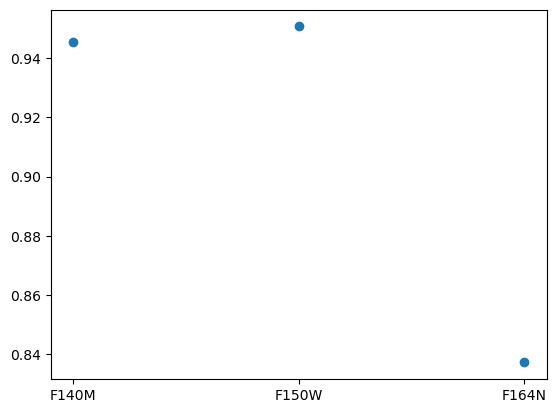

In [5]:
plt.scatter(data['filter'], data['flux']/data['image_flux'])
plt.show()